In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

import os
import joblib
import random
from tqdm import tqdm
import cv2
import numpy as np

In [2]:
DATA_DIR = 'E:\dataset'
TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'training_set/training_set')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'test_set/test_set')

In [3]:
IMG_SIZE = 64
CATEGORIES = []

for i in os.listdir(TRAIN_DATA_DIR):
    CATEGORIES.append(i)
    
print(CATEGORIES)

['cats', 'dogs']


In [21]:
training_data = []

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c)
    class_num = CATEGORIES.index(c) # 0
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   # read the image
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize the image
            training_data.append([img_resized, class_num]) 
        except Exception as e:
            pass
        
print(len(training_data))

100%|█████████████████████████████████████████████████████████████████████████████| 4006/4006 [00:12<00:00, 328.94it/s]

8005


In [20]:
test_data = []

for c in CATEGORIES:
    path = os.path.join(TEST_DATA_DIR, c) 
    class_num = CATEGORIES.index(c) 
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
            test_data.append([img_resized, class_num])
        except Exception as e:
            pass
        
print(len(test_data))

100%|█████████████████████████████████████████████████████████████████████████████| 1013/1013 [00:03<00:00, 332.96it/s]

2023


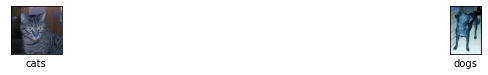

In [38]:
plt.figure(figsize=(30,15))
i=0
for c in CATEGORIES:  
    path = os.path.join(TRAIN_DATA_DIR,c)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.subplot(15,5,i+1)
        plt.imshow(img_array)
        plt.xlabel(c)
        plt.xticks([])
        plt.yticks([])
        i += 1
        break

plt.tight_layout()        
plt.show()

In [22]:
random.shuffle(training_data)
random.shuffle(test_data)

In [23]:
X_train = []
Y_train = []

for img, label in training_data:
    X_train.append(img)
    Y_train.append(label)
    
X_train = np.array(X_train).astype('float32').reshape(-1,64,64,3)
Y_train = np.array(Y_train)

print(f"X_train= {X_train.shape} Y_train= {Y_train.shape}")

X_train= (8005, 64, 64, 3) Y_train= (8005,)


In [24]:
X_test = []
Y_test = []

for features,label in test_data:
    X_test.append(features)
    Y_test.append(label)

X_test = np.array(X_test).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_test = np.array(Y_test)

print(f"X_test= {X_test.shape} Y_test= {Y_test.shape}")

X_test= (2023, 64, 64, 3) Y_test= (2023,)


In [26]:
mean_rgb = np.mean(X_train, axis=(0,1,2))
print(mean_rgb)

[ 99.713196 112.142365 123.337326]


In [27]:
X_train_norm = np.empty_like(X_train)
X_test_norm = np.empty_like(X_test)

In [28]:

for i in range(len(X_train)):
    for c in range(3):
        if(c==1):
            X_train_norm[i,:, :, c] = X_train[i,:, :, c] - mean_rgb[0]
        elif(c==2):
            X_train_norm[i,:, :, c] = X_train[i,:, :, c] - mean_rgb[1]
        else:
            X_train_norm[i,:, :, c] = X_train[i,:, :, c] - mean_rgb[2]
            
for i in range(len(X_test)):
    for c in range(3):
        if(c==1):
            X_test_norm[i,:, :, c] = X_test[i,:, :, c] - mean_rgb[0]
        elif(c==2):
            X_test_norm[i,:, :, c] = X_test[i,:, :, c] - mean_rgb[1]
        else:
            X_test_norm[i,:, :, c] = X_test[i,:, :, c] - mean_rgb[2]

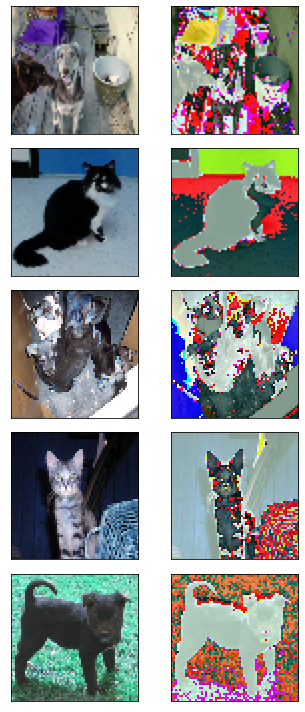

In [29]:
c = 0
plt.figure(figsize=(5,10))
for i in range(5):
    plt.subplot(5,2,c+1)
    plt.imshow(X_train[i].astype('uint8'))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(5,2,c+2)
    plt.imshow(X_train_norm[i].astype('uint8'))
    plt.xticks([])
    plt.yticks([])

    c += 2
    
plt.tight_layout()
plt.show()

In [34]:
model = keras.Sequential([
    ## input layer
    keras.Input(shape=X_train_norm.shape[1:]),
    
    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    
    
    
    
    
    layers.Flatten(),
    
    layers.Dense(units=256),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    
    layers.Dense(units=256),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(10),
    layers.Activation('softmax')
])

model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_10 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
activation_11 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)              

In [35]:
model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [36]:
cb = EarlyStopping(monitor='val_loss', min_delta=0.02, patience=3, restore_best_weights=True)

h = model.fit(x=X_train_norm, y=Y_train, 
              epochs=2, 
              validation_split=0.2,
              batch_size=64,
              callbacks=[cb]
             )

Epoch 1/2
101/101 [==============================] - 18s 157ms/step - loss: 44.1302 - accuracy: 0.4703 - val_loss: 0.7046 - val_accuracy: 0.5528
Epoch 2/2
101/101 [==============================] - 15s 150ms/step - loss: 0.7629 - accuracy: 0.5647 - val_loss: 0.6595 - val_accuracy: 0.6221


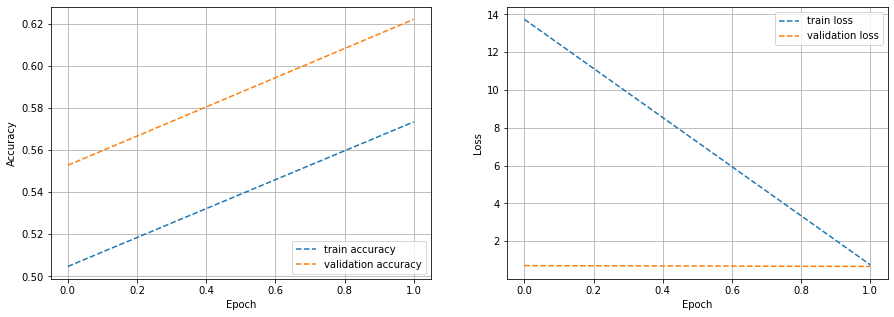

In [37]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'], '--', label='train accuracy')
plt.plot(h.history['val_accuracy'], '--', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'], '--', label='train loss')
plt.plot(h.history['val_loss'], '--', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()